# MSDS 7331 Mini - Project 1  

## SVM and Logistic Modeling

Professor: Dr. Jake Drew  
Team: Steven Hayden, Josephine MacDaniel, Korey MacVittie, Afreen Siddiqui, Eduardo Cantu

## Models

In [2]:
#load Libraries
import pandas as pd
import numpy as np
import seaborn as seaborn
import matplotlib.pyplot as plt
import matplotlib as mp1
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
#Load Data
Accident_df_2016 = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/accident_2016.csv',low_memory=False)
Accident_df_2015 = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/accident_2015.csv',low_memory=False)
Accident_df = pd.concat([Accident_df_2015,Accident_df_2016])

### Data Cleaning

In [31]:
# Displays the record count of non-null Values per attribute and their data type. 
Accident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66978 entries, 0 to 34438
Data columns (total 71 columns):
Unnamed: 0                                                     66978 non-null int64
state_number                                                   66978 non-null int64
state_name                                                     66978 non-null object
consecutive_number                                             66978 non-null int64
number_of_vehicle_forms_submitted_all                          66978 non-null int64
number_of_motor_vehicles_in_transport_mvit                     66978 non-null int64
number_of_parked_working_vehicles                              66978 non-null int64
number_of_forms_submitted_for_persons_not_in_motor_vehicles    66978 non-null int64
number_of_persons_not_in_motor_vehicles_in_transport_mvit      66978 non-null int64
number_of_persons_in_motor_vehicles_in_transport_mvit          66978 non-null int64
number_of_forms_submitted_for_persons_in_motor_veh

In [4]:

#check for duplicate records. It displays the maximum count of a duplicated record. 
#Any value greater than 1 would mean that the data has duplicates
Accident_df['consecutive_number'].value_counts().max()


2

In [5]:
#Drop duplicate records and keeps the most recent record. We assume the most resent is the most accurate 
Accident_df = Accident_df.drop_duplicates(['consecutive_number'],keep = 'last')

#check for duplicate records. It displays the maximum count of a duplicated record . 
#Any value greater than 1 would mean that the data has duplicates
Accident_df['consecutive_number'].value_counts().max()

1

There are many accidents with missing data regarding the crash time and the arrival time of responders. This information is necessary for the dependent variable, and in turn is crucial for our analysis. That is why we decided to drop these records with missing data, instead of imputing the gaps with the mean. The amount of records dropped is about a third of the original data set, but we have sufficient records that this should not prove to be a problem.

In [6]:
#Remove any recoreds without  time informaiton for arival and crash time
count_no_rec= Accident_df[(Accident_df['hour_of_crash']>24) | (Accident_df['hour_of_arrival_at_scene']>24)]
Accident_df = Accident_df[(Accident_df['hour_of_crash']<=24) & (Accident_df['hour_of_arrival_at_scene']<=24)]
print(count_no_rec.consecutive_number.count(), 'records were removed due to missing time data.') 


(19149, 'records were removed due to missing time data.')


In [7]:
# Add a new Feature. This is the ratio between the number of fatalities and the people involved in the accident.
Accident_df['Fatalities_ratio'] = Accident_df.number_of_fatalities/(Accident_df.number_of_persons_not_in_motor_vehicles_in_transport_mvit + Accident_df.number_of_persons_in_motor_vehicles_in_transport_mvit)

#Converts hour and min to datetime type
#crash
Accident_df.hour_of_crash = pd.to_timedelta(Accident_df.hour_of_crash,unit ='h')
Accident_df.minute_of_crash= pd.to_timedelta(Accident_df.minute_of_crash,unit ='m')
#arrival
Accident_df.hour_of_arrival_at_scene = pd.to_timedelta(Accident_df.hour_of_arrival_at_scene,unit ='h')
Accident_df.minute_of_arrival_at_scene = pd.to_timedelta(Accident_df.minute_of_arrival_at_scene,unit ='m')

#concatenates Hour and Minutes together 
Accident_df['Crash_Time'] = Accident_df['hour_of_crash'] + Accident_df['minute_of_crash'] 
Accident_df['Arrival_Time'] = Accident_df['hour_of_arrival_at_scene'] + Accident_df['minute_of_arrival_at_scene']
#creates a response_time variable from the two fields above and converts to min
Accident_df['Response_Time'] = Accident_df['Arrival_Time'] - Accident_df['Crash_Time']
total_response_time_in_min = pd.DatetimeIndex(Accident_df['Response_Time'])
Accident_df['Response_Time']= total_response_time_in_min.hour * 60 + total_response_time_in_min.minute


#gut check of calculation 
Accident_df[['hour_of_crash','minute_of_crash','Crash_Time','hour_of_arrival_at_scene','minute_of_arrival_at_scene','Arrival_Time','Response_Time']].head()

,hour_of_crash,minute_of_crash,Crash_Time,hour_of_arrival_at_scene,minute_of_arrival_at_scene,Arrival_Time,Response_Time
196,20:00:00,00:47:00,20:47:00,21:00:00,00:01:00,21:01:00,14
240,19:00:00,00:10:00,19:10:00,19:00:00,00:24:00,19:24:00,14
274,14:00:00,00:18:00,14:18:00,14:00:00,00:25:00,14:25:00,7
312,23:00:00,00:23:00,23:23:00,23:00:00,00:29:00,23:29:00,6
959,16:00:00,00:01:00,16:01:00,16:00:00,00:12:00,16:12:00,11


The National Fire Protection Association (NFPA) has established a standard for response time and procedures for Emergency Medical Services (EMS) to adhere to.

From EMSword.com, "The NFPA 1710 standard is based upon a combination of accepted practices and more than 30 years of study, research, testing and validation. Members of the 1710 committee that developed the standard include representatives from various fire agencies and the International Association of City/County Managers (ICMA)."

The NFPA 1710 standard allows for a one-minute call for evaluation and preparation, and four minutes for the arrival of a unit with first responders. For a situation that requires advanced life support equipment, such as an ambulance, the standard is eight minutes after call preparation.  

We chose to use their standards as a threshold to determine if paramedics got to the scene of the accident "in time." This would be a binary response of "0" for not arriving within 9 minutes of the accident, with "1" representing being within the 9 minutes. 

Source: https://www.emsworld.com/article/10324786/ems-response-time-standards

In [8]:
#creates the binary variable 'within 9 minutes NFPA standard'
Accident_df['within 9 minutes NFPA standard'] = np.where(Accident_df['Response_Time']<=9,1,0)
#Accident_df[['Response_Time','within 9 minutes NFPA standard']].head(10) # Verify the binary variable

Since the logistic regression will predict if the paramedics arrived to the scene of the accident within the target window, we would select the attributes that we think affect this variable. Generally, we suspect that weather conditions, type of road, and state may play a role.

First we would check what columns are available.

In [9]:
#Displays all the available attributes on the dataset
Accident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16230 entries, 196 to 34438
Data columns (total 76 columns):
Unnamed: 0                                                     16230 non-null int64
state_number                                                   16230 non-null int64
state_name                                                     16230 non-null object
consecutive_number                                             16230 non-null int64
number_of_vehicle_forms_submitted_all                          16230 non-null int64
number_of_motor_vehicles_in_transport_mvit                     16230 non-null int64
number_of_parked_working_vehicles                              16230 non-null int64
number_of_forms_submitted_for_persons_not_in_motor_vehicles    16230 non-null int64
number_of_persons_not_in_motor_vehicles_in_transport_mvit      16230 non-null int64
number_of_persons_in_motor_vehicles_in_transport_mvit          16230 non-null int64
number_of_forms_submitted_for_persons_in_motor_v

From all the attributes in the dataset, we will select a subset to predict whether or not emergency responders would respond within the target window.

* **state_name:** Due to differences in size and funding, it is possible that the state in which an accident occurs may play a role.
* **route_signing_name:** The type of roadway will probably play a role, as some road types may cover areas that are more distant from dispatch locations.
* **light_condition_name:** The local lighting would certainly seem to be important in determining if responders are able to respond in time: darkness is more dangerous to drive in than light.
* **atmospheric_conditions_name:** Weather conditions will almost certainly play a role.
* **within 9 minutes NFPA standard:** Our response variable. A 1 indicates that emergency services responded within the target window, which is 9 minutes. A 0 indicates that responders arrived outside the target window.

In [10]:
#Make a copy of the original Data
Accident_forLr=Accident_df.copy()

# 1. Remove attributes that just arent useful for us
for col in ['Unnamed: 0',
             'state_number',
             'consecutive_number',
             'county',
             'city',
             'day_of_crash',
             'month_of_crash',
             'year_of_crash',
             'day_of_week',
             'hour_of_crash',
             'minute_of_crash',
             'national_highway_system',
             'land_use',
             'land_use_name',
             'functional_system',
             'functional_system_name',
             'ownership',
             'ownership_name',
             'route_signing',
             'trafficway_identifier',
             'trafficway_identifier_2',
             'latitude',
             'longitude',
             'special_jurisdiction',
             'special_jurisdiction_name',
             'first_harmful_event',
             'first_harmful_event_name',
             'manner_of_collision',
             'manner_of_collision_name',
             'relation_to_junction_within_interchange_area',
             'relation_to_junction_specific_location',
             'relation_to_junction_specific_location_name',
             'type_of_intersection',
             'work_zone',
             'relation_to_trafficway',
             'relation_to_trafficway_name',
             'light_condition',
             'atmospheric_conditions_1',
             'atmospheric_conditions_1_name',
             'atmospheric_conditions_2',
             'atmospheric_conditions_2_name',
             'atmospheric_conditions',
             'school_bus_related',
             'rail_grade_crossing_identifier',
             'hour_of_notification',
             'minute_of_notification',
             'hour_of_arrival_at_scene',
             'minute_of_arrival_at_scene',
             'hour_of_ems_arrival_at_hospital',
             'minute_of_ems_arrival_at_hospital',
             'related_factors_crash_level_1',
             'related_factors_crash_level_1_name',
             'related_factors_crash_level_2',
             'related_factors_crash_level_2_name',
             'related_factors_crash_level_3',
             'related_factors_crash_level_3_name',
             'milepoint',
             'number_of_parked_working_vehicles',
             'number_of_forms_submitted_for_persons_not_in_motor_vehicles',
             'number_of_persons_not_in_motor_vehicles_in_transport_mvit',
             'number_of_persons_in_motor_vehicles_in_transport_mvit',
             'number_of_forms_submitted_for_persons_in_motor_vehicles',
             'timestamp_of_crash',
             'number_of_fatalities',
             'number_of_drunk_drivers',
             'Fatalities_ratio',
             'number_of_vehicle_forms_submitted_all',
             'Crash_Time',
             'Arrival_Time',
             'Response_Time',
             'number_of_motor_vehicles_in_transport_mvit']:
                    if col in Accident_forLr:
                        del Accident_forLr[col]
# List the columns left in the df
list(Accident_forLr)

#Accident_forLr.head(20)

['state_name',
 'route_signing_name',
 'light_condition_name',
 'atmospheric_conditions_name',
 'within 9 minutes NFPA standard']

Any observation value on the selected attributes that is reported as *Unknown*, *Other*, or *Not Reported* would be removed from the dataset. These values do not bring any value when it comes to predicting the response time of the paramedics, and are effectively a non-value for our purposes.

In [11]:
# Check for columns that might not be needed
print("Unique values for 'route_signing_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'atmospheric_conditions_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'light_condition_name':" , Accident_forLr.light_condition_name.unique())


("Unique values for 'route_signing_name':", array(['Rain', 'Snow', 'Clear', 'Cloudy', 'Unknown', 'Sleet, Hail',
       'Blowing Snow', 'Not Reported', 'Fog, Smog, Smoke',
       'Severe Crosswinds', 'Freezing Rain or Drizzle',
       'Blowing Sand, Soil, Dirt', 'Other'], dtype=object), '\n')
("Unique values for 'atmospheric_conditions_name':", array(['Rain', 'Snow', 'Clear', 'Cloudy', 'Unknown', 'Sleet, Hail',
       'Blowing Snow', 'Not Reported', 'Fog, Smog, Smoke',
       'Severe Crosswinds', 'Freezing Rain or Drizzle',
       'Blowing Sand, Soil, Dirt', 'Other'], dtype=object), '\n')
("Unique values for 'light_condition_name':", array(['Dark \xe2\x80\x93 Not Lighted', 'Daylight',
       'Dark \xe2\x80\x93 Lighted', 'Dusk', 'Dawn',
       'Dark \xe2\x80\x93 Unknown Lighting', 'Not Reported', 'Unknown',
       'Other'], dtype=object))


In [12]:
# Removes observations with an unknown informaiton in the route, atmospheric conditions and state name
Accident_forLr= Accident_forLr[(Accident_forLr['route_signing_name'] != 'Unknown')]
Accident_forLr= Accident_forLr[(Accident_forLr['route_signing_name'] != 'Other')]
Accident_forLr= Accident_forLr[(Accident_forLr['atmospheric_conditions_name'] != 'Unknown')]
Accident_forLr= Accident_forLr[(Accident_forLr['atmospheric_conditions_name'] != 'Other')]
Accident_forLr= Accident_forLr[(Accident_forLr['atmospheric_conditions_name'] != 'Not Reported')]
Accident_forLr= Accident_forLr[(Accident_forLr['light_condition_name'] != 'Unknown')]
Accident_forLr= Accident_forLr[(Accident_forLr['light_condition_name'] != 'Other')]
Accident_forLr= Accident_forLr[(Accident_forLr['light_condition_name'] != 'Not Reported')]
Accident_forLr.count()

state_name                        14706
route_signing_name                14706
light_condition_name              14706
atmospheric_conditions_name       14706
within 9 minutes NFPA standard    14706
dtype: int64

Here we have confirmed that the undesired observations have been removed from the dataset.

In [13]:
print("Unique values for 'route_signing_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'atmospheric_conditions_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'light_condition_name':" , Accident_forLr.light_condition_name.unique())

("Unique values for 'route_signing_name':", array(['Rain', 'Snow', 'Clear', 'Cloudy', 'Sleet, Hail', 'Blowing Snow',
       'Fog, Smog, Smoke', 'Severe Crosswinds',
       'Freezing Rain or Drizzle', 'Blowing Sand, Soil, Dirt'],
      dtype=object), '\n')
("Unique values for 'atmospheric_conditions_name':", array(['Rain', 'Snow', 'Clear', 'Cloudy', 'Sleet, Hail', 'Blowing Snow',
       'Fog, Smog, Smoke', 'Severe Crosswinds',
       'Freezing Rain or Drizzle', 'Blowing Sand, Soil, Dirt'],
      dtype=object), '\n')
("Unique values for 'light_condition_name':", array(['Dark \xe2\x80\x93 Not Lighted', 'Daylight',
       'Dark \xe2\x80\x93 Lighted', 'Dusk', 'Dawn',
       'Dark \xe2\x80\x93 Unknown Lighting'], dtype=object))


In [14]:
# Rearrange colums
Accident_forLr=Accident_forLr[['within 9 minutes NFPA standard','state_name','route_signing_name','atmospheric_conditions_name','light_condition_name']]
#list(Accident_forLr)  # Check for the correct column sequence

The section below will perform a one-hot encoding of the variables on the dataset. This is to prepare the data in such a way that can be use for our logistic regresion.

In [15]:
# perform one-hot encoding of the categorical data "state_name"
tmp_state_df = pd.get_dummies(Accident_forLr.state_name,prefix='state')
#tmp_state_df.head(20)

# perform one-hot encoding of the categorical data "route_signing_name"
tmp_route_df = pd.get_dummies(Accident_forLr.route_signing_name,prefix='route')
#tmp_route_df.head(20)

# perform one-hot encoding of the categorical data "atmospheric_conditions_name"
tmp_atmos_df = pd.get_dummies(Accident_forLr.atmospheric_conditions_name,prefix='atmos')
#tmp_atmos_df.head(20)

# perform one-hot encoding of the categorical data "atmospheric_conditions_name"
tmp_light_df = pd.get_dummies(Accident_forLr.light_condition_name, prefix='light')
#tmp_atmos_df.head(20)

Accident_forLr = pd.concat((Accident_forLr,tmp_state_df,tmp_route_df,tmp_atmos_df,tmp_light_df), axis=1) # add back into the dataframe
list(Accident_forLr)
#delete the categorical variable columns
del Accident_forLr['state_name']
del Accident_forLr['route_signing_name']
del Accident_forLr['atmospheric_conditions_name']
del Accident_forLr['light_condition_name']

#list(Accident_forLr) # Check for the last colums

In [16]:
#Accident_forLr.count() # Count Records and show columns
#Accident_forLr['within 9 minutes NFPA standard'].sum()

## Logistic Regression Model

### Data Split and Cross Validation Setup
In this logistic regresion we would be splitting our dataset into a Training and Test set. The split is going to be 80 % for training and the other 20 % for testing. The ratio used is accepted split in the research community, and we did not see any reason to deviate from this ratio. A Cross Validation of ten fold would be performed to validate the model. 

* Binary Response: *"within 9 minutes NFPA standard"*

|Value|Description|
|-----|:-----------|
|0| Time of arrival > 9 minutes|
|1| Time of arrival <=9 minutes|

* To ensure that we use the same randomly-selected test and training sets each time we perform the cross-validation, we have specifically set a seed for our random number generator

In [17]:
# Code addapted from the Dataming Notbooks. Logistic Regression Notbook 4.
#URL: https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'within 9 minutes NFPA standard' in Accident_forLr:
    y = Accident_forLr['within 9 minutes NFPA standard'].values # get the labels we want
    del Accident_forLr['within 9 minutes NFPA standard'] # get rid of the class label
    X = Accident_forLr.values # use everything else to predict!
    
        ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
        #    have converted them into simple matrices to use with scikit learn

# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10  #number of Cross Validation folds
num_instances = len(y)

# Cross Validation Object
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2,
                         random_state=0)
                         
print(X) # This prints all the dependant variables
print(cv_object) # This print the Data split object

# Duplicates data for Discussion  later
Accident_forLr_chart=Accident_forLr

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None)


### Logistic Regression Model Setup  
This will use the **cv_object** to run the cross validation for the logistic regression on the *within 9 minutes NFPA standard* binary varable. At this point the data has been split into training and test. 

The setup for this model would be:
* **Penalty: L2**  
    L2-Norm also known as least square error (LSE). This will be used for the penalization in the model.
* **Cost (C): 1**  
    The value of '1' is the defaul for this logistic regression. In combination with the penalty L2, the smaller values of C (<1) will constrain the model, on the other hand large values will give more freedom to the model. 
    
* **Class_Weight: None**  
    Since the response variable is nearly balance, where 44% are '1' and 56% are '0'. We would leave this parameter as None.

In [18]:
# Code addapted from the Dataming Notbooks. Logistic Regression Notbook 4.
#URL: https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
OnTime_lr_clf = LogisticRegression(penalty='l2', C=1, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
acc_List = []
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    OnTime_lr_clf.fit(X_train,y_train)  # train object
    y_hat = OnTime_lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    acc_List.append(acc)
    iter_num+=1

    
# The Code above randomly creates a new training and testing set
# so there will multiple accuracy measurements
# We have taken the of all these measurements below

print('\n','\n','\n','\n',"==========================") 
print("average accuracy",np.mean(acc_List))



('====Iteration', 0, ' ====')
('accuracy', 0.6427600271923861)
('confusion matrix\n', array([[1270,  364],
       [ 687,  621]], dtype=int64))
('====Iteration', 1, ' ====')
('accuracy', 0.6363018354860639)
('confusion matrix\n', array([[1273,  371],
       [ 699,  599]], dtype=int64))
('====Iteration', 2, ' ====')
('accuracy', 0.6543167912984365)
('confusion matrix\n', array([[1285,  381],
       [ 636,  640]], dtype=int64))
('====Iteration', 3, ' ====')
('accuracy', 0.6505778382053025)
('confusion matrix\n', array([[1273,  385],
       [ 643,  641]], dtype=int64))
('====Iteration', 4, ' ====')
('accuracy', 0.650237933378654)
('confusion matrix\n', array([[1288,  369],
       [ 660,  625]], dtype=int64))
('====Iteration', 5, ' ====')
('accuracy', 0.6393609789259007)
('confusion matrix\n', array([[1264,  369],
       [ 692,  617]], dtype=int64))
('====Iteration', 6, ' ====')
('accuracy', 0.6312032630863358)
('confusion matrix\n', array([[1247,  357],
       [ 728,  610]], dtype=int64))


The mean of the 10-fold cross validation is indicated above. This value is using the selected parameter values described earlier.

#### Grid Search
On this section we will perform a serch for the best model using *Grid Search*. As per the previous model were the parameter values used to be fixed, in this section a range of parameters is given, and the search algorithm will iterate through all parameter conbinations.

In this search we would go through 64 possible model combinations. From these model combinations, the algorithm will pick the one with the highest accuracy. 

The search parameter matrix will include:
* **Penalty:** L2. This remains fixed, since solver 'sag' only takes L2 penalties.
* **C (Cost):** It will test eight values: (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000)
* **Random State**: It will stay at 0. This is just the random seed. 
* **Solver:** Two modes will be tested under this parameter: 'sag','liblinear'. These are the algorithm for the optimzation problem. The first algorithm is optimized for large datasets, the second is not.

In [19]:

# Code addapted from the notebook 'ComparingSegregatedHighSchoolCampuses.ipynb' to make a grid search for the best model
#URL:https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedHighSchoolCampuses.ipynb
parameters = { 'penalty':['l2']
              ,'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', None]
              ,'random_state': [0]
              ,'solver': ['sag','liblinear']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=OnTime_lr_clf
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_object # KFolds = 10
                   , scoring='accuracy')

# Perform the seaarch throught all the parameters in the parameters dictionary
regGridSearch.fit(X, y)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   24.6s
[Parallel(n_jobs=8)]: Done 640 out of 640 | elapsed:  1.2min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['sag', 'liblinear'], 'max_iter': [100, 500], 'penalty': ['l2'], 'random_state': [0], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [20]:
#Diplay the top model parameters
print(regGridSearch.best_estimator_)

# Display the Best Score of the iteration search
print('\nThe best accuracy score from the search is:', regGridSearch.best_score_ )

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)
('\nThe best accuracy score from the search is:', 0.6461250849762067)


The Grid Search has obtained optimal parameters from the parameter matrix. These parameters would be stored in the **OntimeClassifierEst**. This object contains the model with the highest accuracy from the grid search.

Next, the model with the optimal parameters would be used with a cross validation of ten fold again, to see if there is an improvement from the original where the parameters remained fixed. 

The main differences betweem the two approachs are:  

|Parameter|Fixed Model|Grid Search|
|---------|---------|:---------:|
|class_weight| None |Balanced|
|Cost (C) | 1 | 0.1 |
|Solver|liblinear | sag|
|Ten Fold Avg Accuracy| 0.64140 | 0.64588 |

In [21]:
from sklearn.model_selection import cross_validate

#Use the best parameters for our Linear Regression object
OntimeClassifierEst = regGridSearch.best_estimator_

bestScores = cross_validate(OntimeClassifierEst,X,y,scoring=['accuracy','precision','recall'], cv=cv_object, return_train_score=True)


# grab the results from the dictionary into a dataframe
cvScoreResult = pd.DataFrame()
cvScoreResult['Accuracy'] = bestScores['test_accuracy']
cvScoreResult['Precision'] = bestScores['test_precision']
cvScoreResult['Recall'] = bestScores['test_recall']


print('Cross Validation Fold -- Mean Error Scores')
print(cvScoreResult)

avgAccuracy = bestScores['test_accuracy'].mean()
avgPrecision = bestScores['test_precision'].mean()
avgRecall = bestScores['test_recall'].mean()


avgAccStr = "\nAverage accuracy for all cv folds is: \t {avgAccuracy:.5}"
avgPrcStr = "Average precision for all cv folds is: \t {avgPrecision:.5}"
avgRecStr = "Average recall for all cv folds is: \t {avgRecall:.5}"

print(avgAccStr.format(avgAccuracy=avgAccuracy))
print(avgPrcStr.format(avgPrecision=avgPrecision))
print(avgRecStr.format(avgRecall=avgRecall))
print('*********************************************************')

Cross Validation Fold -- Mean Error Scores
   Accuracy  Precision    Recall
0  0.642760   0.608439  0.551223
1  0.641061   0.611418  0.511556
2  0.656016   0.609272  0.576803
3  0.648199   0.606501  0.552181
4  0.653977   0.613617  0.561089
5  0.643440   0.609797  0.551566
6  0.632903   0.607500  0.544843
7  0.655337   0.612769  0.574650
8  0.643780   0.627060  0.539150
9  0.643780   0.621806  0.547226

Average accuracy for all cv folds is: 	 0.64613
Average precision for all cv folds is: 	 0.61282
Average recall for all cv folds is: 	 0.55103
*********************************************************


The result obtained from the cross validation using the linear regression model with the optimized parameters is 0.00367 better than the one obtained with fixed parameters. Although there is a minimal difference, there may be practical implications for this small difference.

Now we would compare the both models using the same training and data sets, to determine the difference. From the results, we can see that the grid search model has a slight advantage over fixed parameters. This improvement comes from making better predictions for cases in which the response time is 0 (over the 9-minute threshold), but at the same time the predictions for on-time are not as accurate as in the fixed model.

In [24]:
# Using the Grid Search
y_hat_SearchGrid = OntimeClassifierEst.predict(X_test)
conf_SearchGrid=mt.confusion_matrix(y_test,y_hat_SearchGrid)
acc_SearchGrid = mt.accuracy_score(y_test,y_hat_SearchGrid)

#Using the Fixed Model
y_hat_Fixed = OnTime_lr_clf.predict(X_test)
conf_Fixed=mt.confusion_matrix(y_test,y_hat_Fixed)
acc_Fixed = mt.accuracy_score(y_test,y_hat_Fixed)

print "Accuracy with Fixed Parameters:", acc_Fixed
print "confusion matrix for Logistic Regression with Fixed Parameters\n",conf_Fixed

print "Accuracy with Seach Grid Parameters:", acc_SearchGrid
print "confusion matrix for Logistic Regression with Grid Seach Parameters\n",conf_SearchGrid


Accuracy with Fixed Parameters: 0.6437797416723318
confusion matrix for Logistic Regression with Fixed Parameters
[[1270  338]
 [ 710  624]]
Accuracy with Seach Grid Parameters: 0.6464989802855201
confusion matrix for Logistic Regression with Grid Seach Parameters
[[1166  442]
 [ 598  736]]


Here, we can see that the fixed failures to predict total to 1048, whereas for the search grid they total to 1040, indicating that the search grid is marginally more accurate (reflected in the accuracy percentages: 64.38% *v.* 64.65%).

### Support Vector Machine Model

In [25]:
# Code to run through the cross validation loop and set the training and testing variable for one single iteration 
#Code addapted from the Dataming Notbooks. Logistic Regression and SVM Notbook 4
#URL: https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
from sklearn.preprocessing import StandardScaler
for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
#scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

D:\Codeland\Anaconda2\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Text(0.5,1,u'SVC With linear kernel for first 100 records')

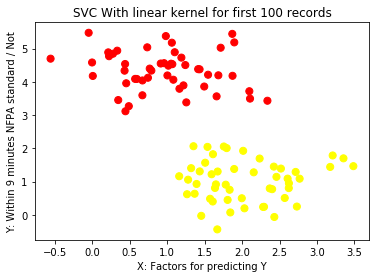

In [27]:
# A case of a simple classification task, in which the two classes of points are well separated:

from sklearn.datasets.samples_generator import make_blobs
X1, y1 = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='autumn');
plt.xlabel('X: Factors for predicting Y')
plt.ylabel('Y: Within 9 minutes NFPA standard / Not')
plt.title('SVC With linear kernel for first 100 records')


This graph demonstrates that there is fairly nice separation in our data between records in which the emergency response time was below 9 minutes, and above 9 minutes.

### Linear SVM
Here we are classifying the data into two categorize based on X varaibles i.e if the help has arrived on time or not.

In [28]:
# lets investigate SVMs on the data and play with the parameters and kernels
#Using Linear Kernel (source: https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/)
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train_scaled, y_train) 
 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
#source: https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn
#To make predictions, the predict method of the SVC class is used. 
y_pred = svclassifier.predict(X_test_scaled)

In [30]:
#source: https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn
#Confusion matrix, precision, recall, and F1 measures are the most commonly used metrics for classification tasks. 
#Scikit-Learn's metrics library contains the classification_report and confusion_matrix methods, which can be readily used to find out the values for these important metrics.
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[1222  386]
 [ 695  639]]
             precision    recall  f1-score   support

          0       0.64      0.76      0.69      1608
          1       0.62      0.48      0.54      1334

avg / total       0.63      0.63      0.62      2942



In [31]:
#Cross Validation on SMV model to demonstrates how to estimate the accuracy of a linear kernel support vector machine 
#on the dataset by splitting the data, fitting a model and computing the score consecutive times. 
#http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(svclassifier, X, y, cv=cv)

array([0.63440617, 0.62805984, 0.63236627, 0.63168631, 0.63055304])

In [32]:
#Getting Predictions using cross Validations.
from sklearn.model_selection import cross_val_predict
cv_pred=cross_val_predict(svclassifier, X_train_scaled, y_train, cv=5)
print(cv_pred)

[0 0 1 ... 0 0 1]


Text(0.5,1,u'SVC with linear kernel for first 100 records')

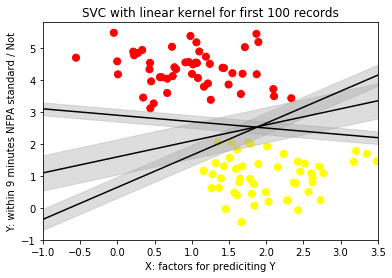

In [33]:
#The intuition is this: rather than simply drawing a zero-width line between the classes,
#we can draw around each line a margin of some width, up to the nearest point.
#https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

xfit = np.linspace(-1, 3.5)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='autumn');

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

plt.xlabel('X: factors for prediciting Y')
plt.ylabel('Y: within 9 minutes NFPA standard / Not')
plt.title('SVC with linear kernel for first 100 records')

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

Here, we can see that there are a few lines that work, in a few different ways.

### Non-Linear SVM

In [34]:
# SVMs on the data, Running the rbf model with scaled data to improve the accuracy 
from sklearn.svm import SVC

# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print 'accuracy:', acc 
print conf

accuracy: 0.6451393609789259
[[1234  374]
 [ 670  664]]


In [35]:
# look at the support vectors
print svm_clf.support_vectors_.shape
print svm_clf.support_.shape
print svm_clf.n_support_ 
print svm_clf.support_

(9149L, 73L)
(9149L,)
[4677 4472]
[    0     3     5 ... 11757 11762 11763]


So the analysis here is basically telling us what the original statistics of the data looked like, and also what the statistics of the support vectors looked like. We can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries, and also instances that are classified incorrectly in the training data.

In [36]:
df_tested_on = Accident_forLr.iloc[train_indices]
df_support = df_tested_on.iloc[svm_clf.support_,:]
svm_clf.support_df = pd.DataFrame(svm_clf.support_)
df_support['within 9 minutes NFPA standard'] = y[svm_clf.support_]# add back in the  Column to the pandas dataframe
Accident_forLr['within 9 minutes NFPA standard'] = y # also add it back in for the original data
#df_support.info()

D:\Codeland\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Model Discussion

Below is a comparison matrix for the model:  

|Characteristics  | Logistic Regression | Suppor Vector Machine|
|---|---------------------|----------------------|
|Run Time| 1.1 min Grid Search | 45 sec |
|Best Accuracy Score | 0.64588 | 0.64513 |
|Cross Validation Support | Yes | No |
|Algorithm Flexibility | 'liblinear', 'sag'| different Kernels |

The data that was used is completely categorical, including the dependent variables. The range on those variables was between 0 and 1, therefore it was not necessary to have them normilized for the models. This helped both the Logistic Regression and SVM approaches to perform very similarly to one another. The difference in accuracy is in the ordinal of a thousand, which is rather small. Another indication of similar performance is that the data could possibly be separated by a line, as we saw earlier. If this were not the case, the SVM could have improved over the regression approach.

The Logistic Regression has features that can improve the time for large datasets. The solve algorithm 'sag' is one of those features, while 'liblinear' algorithm can be use for smaller datasets with improved accuracy. Since the dataset used on this excercise was on the smaller side of datasets, we were able to test both solve algorithms using the Grid Search. The output from Grid Search gave the 'sag' algorithm the best accuracy score; however, the difference in accuracy score between the algorithms was in the ordinal of a thousand, which gives us flexibility in choosing which algorithm to use.

“Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However, it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes very well. we have various options available with kernel like, “linear”, “rbf”, “poly” and others (default value is “rbf”).
For our project we used the Kernel type as Linear and rbf and we figure out that the results are almost equivalent for both the models around 63 for linear model and 65 for rbf model and other factors like precision, recall also have almost the same values. Since the data is good fit to divide linearly we conclude that linear model is the best fit for this data then the rbf model as rbf model is useful for non-linear hyper-plane data.

For this exercise, the output of the models is very similar in terms of accuracy. As such, it's important to understand the data from a variety of angles, before selecting the best approach. In this case, we feel that the logistic regression is the better model.

## Logistic Regression Weight Interpretation

From the “Feature Correlation” chart below, you can easily tell the direction of the relationship each independent variable has. A positive value suggests that, if the variable is true, the likelihood of an on-time arrival would increase as well. We can also can tell the magnitude of the effect by how far each weight is from zero. Since the categorical attributes were all broken out into binary variables, we do not have to scale them for comparison. This makes it much easier to compare the binary variables the magnitude of their effect. All the attributes that have been broken out should be discussed together as they are mutually exclusive.  

The chart below is order from largest impact to smallest. We can find the main drivers of the model by the very first variable in the chart and the last. *state_Rhode Island* has the highest weight of .931, which means if the accident is in Rhode Island, the likelihood of the response being under the standard time goes up by .931 holding all other factors constant. A couple theories why state_Rhode Island has the largest weight is funding is greater for EMS or population per square mile is much greater than some other states. This could mean more building dedicated to EMS and a shorter distance to accidents. More data is needed to investigate if this is contributing to the weight.

Note that these relationships are not linear: a value of .931, for instance, does not directly correspond to a .792 increase in the likelihood of timely arrival. Instead, the relationship functions like a z-score: for the total value taking all factors into account, the percent chance that the response time will be within the target window is equal to the area under the left side of the curve on a z-score distribution.

On the other end of the spectrum *state_Wyoming* is -1.32, meaning if the accident happened on in Wyoming, the EMS arriving within the standard time goes down by -1.32. This could be due the same reason as discussed above, but Wyoming may have less funding and less population per square mile. This would have to be investigated to confirm this.

The *route_signing_name* variable is broken out into seven binary variables. *route_Local Street – Municipality* had the highest weight of .679.  If the accident happens on a street within the Municipality, response time chance would be .679 higher for EMS arriving within NFPA 1710 standard holding all else constant. Municipality is a dense area within a city, and could have more EMS in that area to responded to these accident; EMS hubs like hospitals and such tend to be in denser, more populous areas, and thus accidents that occur within the heart of a city may have a lower response time due to mere proximity.

The *Route_Interstate* variable had a weight of -.549. This is the lowest for all the route_signing_name variables driving down probability the response is within the target window. It seems likely that this is due to the fact that interstates cover large areas and may be most distant from the nearest EMS dispatch locations. However, more research would be needed to better understand this relationship (for instance, data on EMS dispatch locations would be of assistance here).

The atmospheric condition "blowing snow" has a positive relationship of .228. This is surprising, as we would expect that blowing snow would be detrimental to EMS arrival times. This could be due to an unbalanced number of observations in cities that can maintain their roads better during the winter. Further research will be needed to understand this relationship. The *atmos_Sleet* variable had a negative impact with -.303 for EMS arriving within the target window - this is much more sensible, as it would be expected that, as roads get more difficult to navigate during these conditions, the response time would suffer.

*Light condition- lighted* is the greatest positive magnitude variable of the light conditions with .614. This means the probability increase by .614 of EMS making it to the accident within the standard time. As expected *light_Dark – Not Lighted* has a negative impact with -.361 probability of arriving within the target time. 

You can find a list of all weights below along with the chart highlighting the magnitude of each.

In [38]:
# Code addapted from the Dataming Notbooks. Logistic Regression Notbook 4.
#Generates weights from the LR model.
# iterate over the coefficients 

weights = OnTime_lr_clf.coef_.ravel() 

# take transpose to make a column vector

variable_names = Accident_forLr.columns[:-1]

for coef, name in zip(weights,variable_names):
    print name, 'has weight of', coef


state_Alabama has weight of -0.49481794241691424
state_Alaska has weight of 0.23194511802257245
state_Arizona has weight of 0.28551400856988757
state_Arkansas has weight of -0.45959764998975844
state_California has weight of 0.022067274261326875
state_Colorado has weight of 0.5592751589353823
state_Connecticut has weight of 0.783790203148936
state_Delaware has weight of 0.787233521069537
state_District of Columbia has weight of 1.2442344444971343
state_Florida has weight of 0.9200252239627449
state_Georgia has weight of 0.21011950593863568
state_Hawaii has weight of 0.25799357400874756
state_Idaho has weight of -0.04175320410529981
state_Illinois has weight of 0.22270530295700558
state_Iowa has weight of -0.13662446383754065
state_Kansas has weight of -0.7883304518890336
state_Kentucky has weight of 0.08294674716368015
state_Louisiana has weight of -0.35261377491614143
state_Maine has weight of -0.1024423281470797
state_Maryland has weight of -0.6116536066966685
state_Massachusetts has

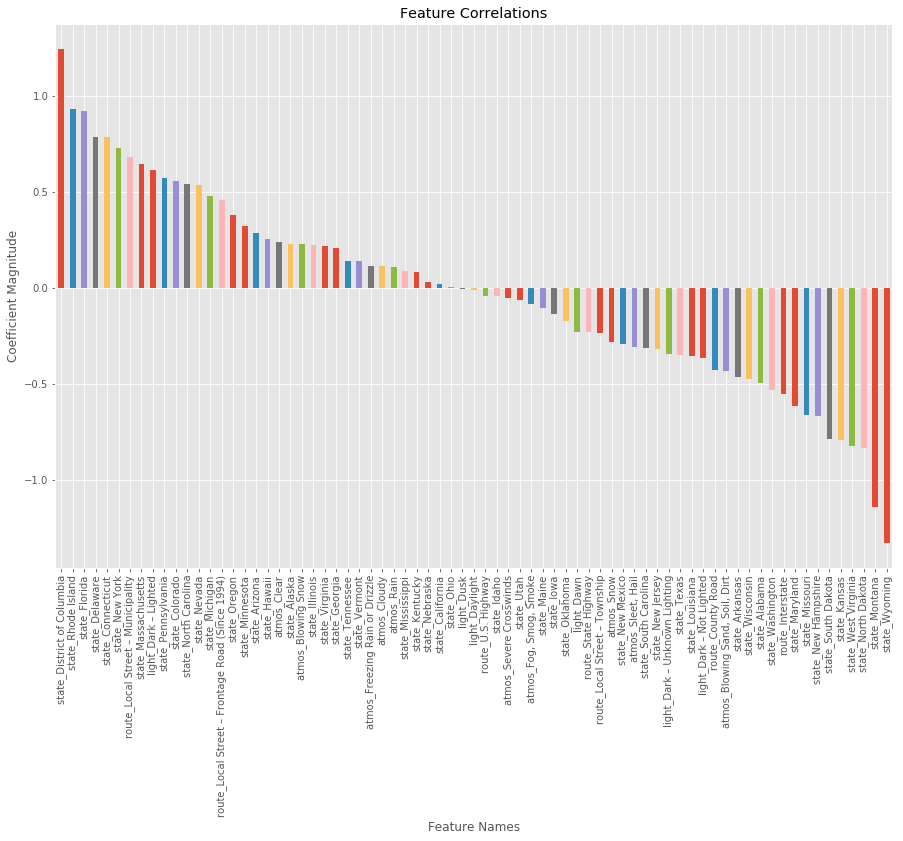

In [39]:
#chart by weight
import scipy.stats as st
weights=OnTime_lr_clf.coef_.ravel()
variable_names = Accident_forLr.columns[:-1]
inRegFt_df = pd.DataFrame({'variables':variable_names, 'weights':weights, 'absolute_weights': np.abs(weights)})

inRegFt_df.sort_values(by='weights', inplace=True, ascending=False )

plt.style.use('ggplot')
weights = pd.Series(inRegFt_df['weights'].values,index=inRegFt_df['variables'])
ax = weights.plot(kind='bar', figsize=(15,10))

ax.set_title("Feature Correlations")
ax.set_ylabel("Coefficient Magnitude")
ax.set_xlabel("Feature Names")
plt.show()


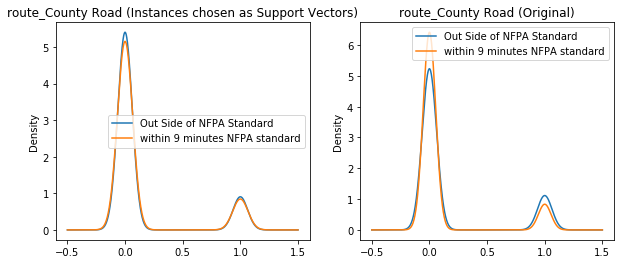

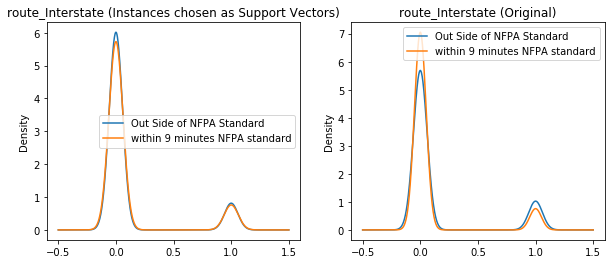

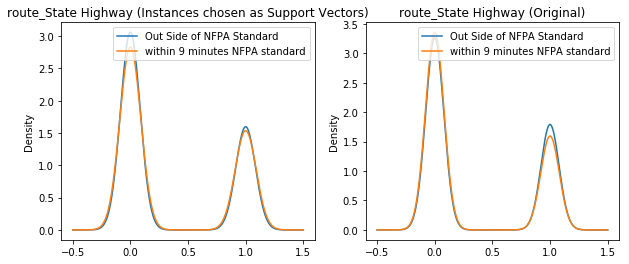

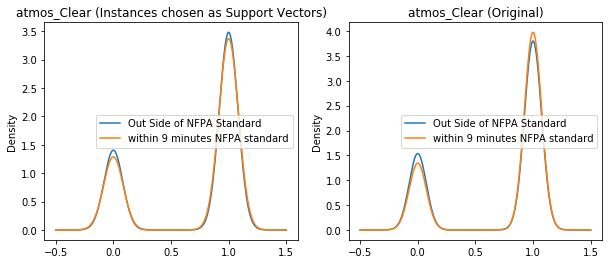

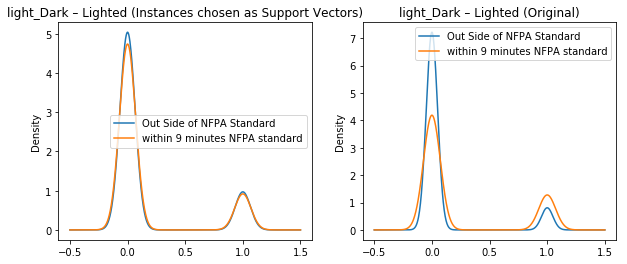

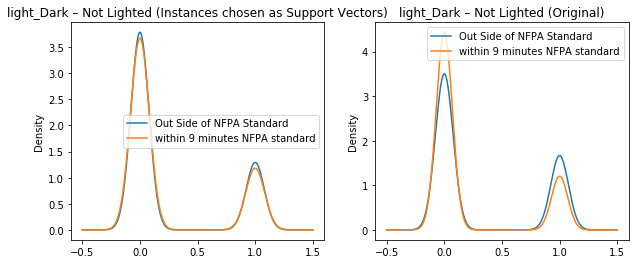

In [66]:

# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors

df_grouped_support = df_support.groupby(['within 9 minutes NFPA standard'])
df_grouped = Accident_forLr.groupby(['within 9 minutes NFPA standard'])

# plot KDE of Different variables
vars_to_plot = ['route_County Road','route_Interstate','route_State Highway','atmos_Clear','light_Dark – Lighted',
               'light_Dark – Not Lighted']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Out Side of NFPA Standard','within 9 minutes NFPA standard'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Out Side of NFPA Standard','within 9 minutes NFPA standard'])
    plt.title(v+' (Original)')

## Insights based on the Classification Task
There are many factors that can affect the emergency responders to be on time during an accident event. However, one factor that has the most impact is the state where the accident happens. This may have to do with the budget that the states has for the emergency responders, the state's driving culture, the state size, and the emergency infrastructure, like road conditions and facilities.

While there were a few surprises in the data - for instance, that "blowing snow" results in a *positive* bias towards emergency services arriving within the target window - almost everything else here is sensible. When we consider the question, "what sort of conditions might make me personally more likely to suffer an accident, or cause someone to be delayed?," the results of our analysis seem to match up rather well. If it's snowing out or after dark, I would expect that to negatively impact my driving, and as such I would similarly expect it to impact the response time of first responders. The data seems to largely reflect our intuitions regarding hazardous driving conditions.

Likewise, more abstract considerations also pan out. It takes longer for emergency services to respond to an accident in Wyoming: when we think of Wyoming, we envision huge, empty spaces, mostly devoid of human life. It thus makes sense that it takes EMS longer to respond to an accident - Wyoming is a vast, essentially desolate space. Conversely, the response time in a state like Rhode Island is much more likely to fall in the target window, and considering that a drive across Rhode Island takes maybe an hour or two (if that), that also seems fairly sensible.

There are some additional statistics that we could have that would help us make sense of this data and tell a more interesting story. For instance, it might be helpful to know how many EMTs there are per capita, in a given state; similarly, the level of funding for such organizations, how many dispatch locations they have, and various other aspects may yield greater insight into why some states have better response times than others. Likewise, more information on the roadways might be helpful: is a particular road well-maintained, or has it fallen into disrepair? How often is a given road traveled?

Though having more data would give us even greater insight, what we have found here is already very informative. These models indicate evidence of strong relationships between weather, state, type of road, and light conditions, and the successful arrival of emergency services within a short window. In an accident, literally every second can make a difference, and the timely arrival of paramedics can spell the difference between life and death for an individual. With just this data in hand, one could make cogent arguments for working to improve response times for services in some areas, and possibly even explain *why* they are falling out of the target window. That demonstrates that this sort of modeling is a useful and powerful tool in helping solve real-world problems.